In [1]:
import sys
from pathlib import Path

import os

import PIL
import numpy as np
import wandb

In [2]:
module_path = str(Path.cwd().parents[0].parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
from plotCreator import *

In [3]:
data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "bh" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "sph" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [4]:
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [5]:
import fastai
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback

In [6]:
# Vi slår sammen dataene for å ha et samlet datasett som kjører gjennom modellen
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [7]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# 75% av datasettet havner i trainData, 25% havner i testData, 
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [24]:
def wrapper(image, lable):    
    def pass_index(idx):
        return idx

    def get_x(i):
        img = image[i]
        img = (img * 255).astype(np.uint8)
        return img
    
    def get_y(i):
        return lable[i]

    db = DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items = pass_index, 
        get_x = get_x, 
        get_y = get_y
    )

    num_images = image.shape[0]
    
    dls = db.dataloaders(list(range(num_images)),bs=64, num_workers=0)
    

    return dls

In [25]:
dls = wrapper(trainData, trainLabels)

In [26]:
learner = vision_learner(dls, resnet34, metrics=accuracy) 

c:\Users\student\Anaconda3\envs\DAT191-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\student\Anaconda3\envs\DAT191-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0010000000474974513)

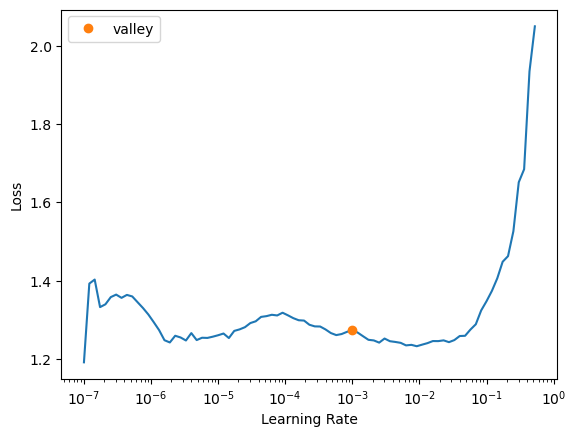

In [27]:
learner.lr_find()

In [ ]:
learner.fine_tune(5)